This notebook demonstrates how to fine-tune a small shader parameter so that its output image matches a reference image using SlangPY, Torch and mean absolute error (MAE) loss.
- Create a Slang device with CUDA interop enabled.
- Load a differentiable Slang shader as a PyTorch module.
- Prepare an input texture and reference image.
- Define and optimize a learnable brightness offset.
- Display input, reference, and optimized output images inline.

In [1]:
import slangpy as spy
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import ipynbname
cwd = ipynbname.path() 
import torch
import torch.nn.functional as F


device = spy.create_device(include_paths=[
        pathlib.Path(cwd).parent.absolute(),
], enable_cuda_interop=True)

IMG_WIDTH = 1024
IMG_HEIGHT = 1024

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.


Errors are too wide for Jupyter, this makes the page wider:
```
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
```

Load source image and reference that we'd like to match:

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

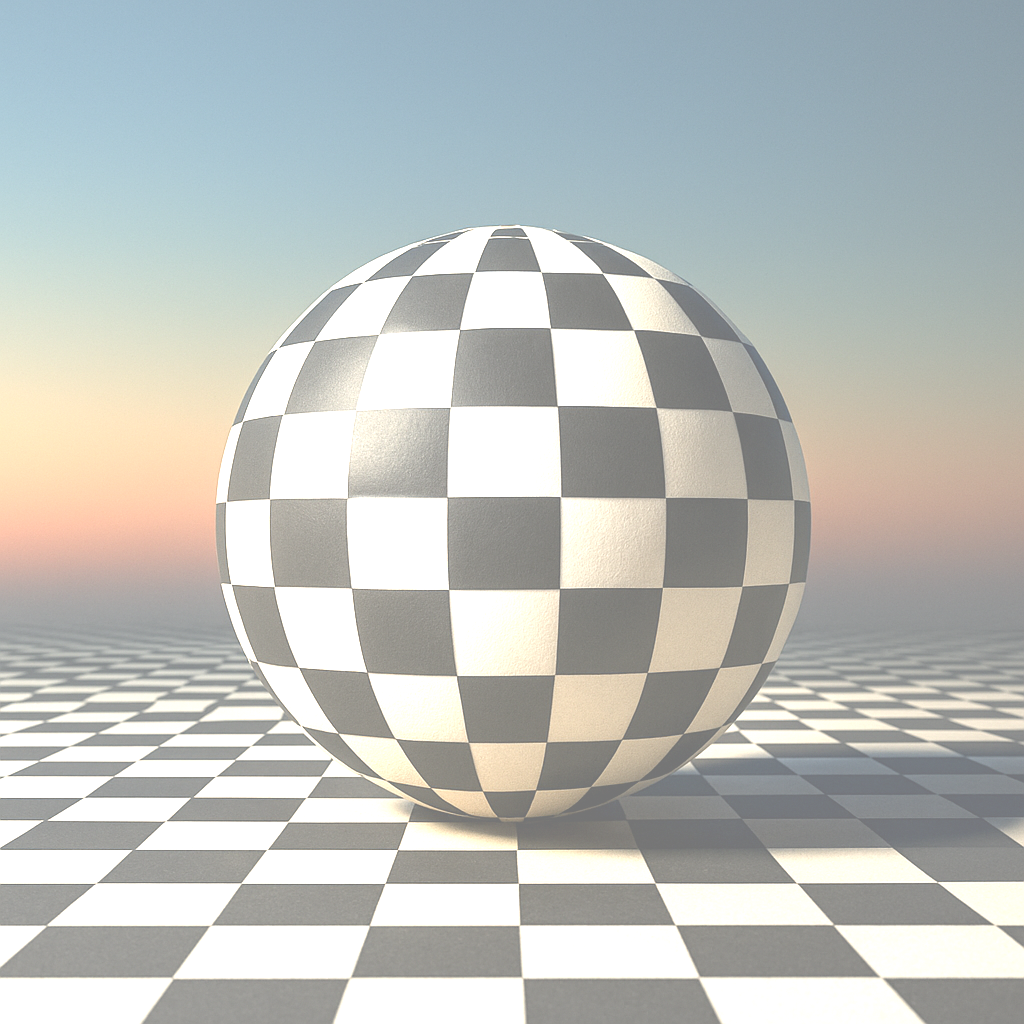

In [3]:
source_bmp = spy.Bitmap("example.png")
source_bmp

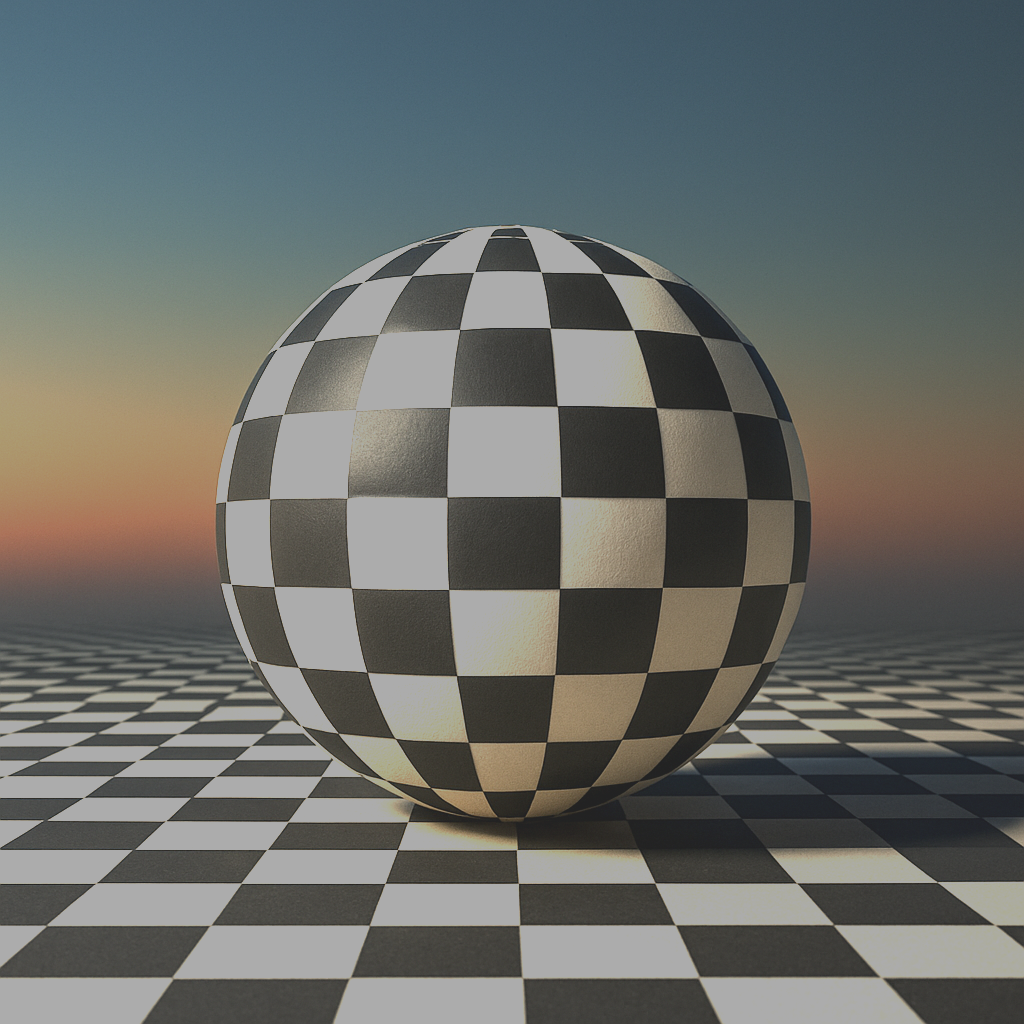

In [4]:
reference_bmp = spy.Bitmap("example_reference.png").convert(pixel_format=spy.Bitmap.PixelFormat.rgb, component_type=spy.Bitmap.ComponentType.float32)
reference_bmp

In [5]:
# Some processing and converting
source_bmp = source_bmp.convert(pixel_format=spy.Bitmap.PixelFormat.rgb, component_type=spy.Bitmap.ComponentType.float32)
source_texture = device.create_texture(
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    format=spy.Format.rgb32_float,
    usage=spy.TextureUsage.shader_resource | spy.TextureUsage.unordered_access,
    data=np.array(source_bmp)
)
reference_array = torch.from_numpy(np.array(reference_bmp)).to('cuda')

### Optimization Loop: Fitting the Brightness Offset

In this cell we iteratively adjust a small RGB brightness offset so that our Slang shader’s output image matches a given reference. We use:

1. An Adam optimizer to update the learnable `ammount` tensor.  
2. A forward pass through the shader (`module.brightness`) to produce the brightened image.  
3. A mean absolute error (L1) loss comparing the shader output to the reference.  
4. Backpropagation (`loss.backward()`) to compute gradients w.r.t. `ammount`.  
5. An optimizer step to update `ammount`, and print progress every 250 iterations.

By the end, `ammount` should converge to values that minimize the MAE between the two images.

In [18]:
# 1) Load the compiled Slang shader as a PyTorch‐compatible module.
#    This lets us call its entry‐points like regular PyTorch functions.
module = spy.TorchModule.load_from_file(device, "examples.slang")

# 2) Initialize a small 3-component brightness offset (R, G, B).
#    We’ll learn this so that brightening `source_texture` matches `reference_array`.
ammount = torch.tensor([-0.1, 0.1, 0.0],
                       dtype=torch.float32,
                       device='cuda',
                       requires_grad=True)   # enable gradient tracking

# 3) Create an optimizer wrapping our learnable parameter.
#    Adam adapts per‐parameter learning rates for more stable convergence.
opt = torch.optim.Adam([ammount], lr=1e-3)

# 4) Run the optimization loop
iters = 10000
for i in range(iters):
    # a) Zero out gradients from the previous iteration
    opt.zero_grad()
    
    # b) Forward pass: call the Slang shader entry-point "brightness"
    #    It returns a tensor of the same shape as `source_texture`.
    result = module.brightness(ammount, source_texture)
    
    # c) Compute the mean absolute error (L1) between the output and reference
    loss = F.l1_loss(result, reference_array)
    
    # d) Backward pass: populate `ammount.grad` with d(loss)/d(ammount)
    loss.backward()
    
    # e) Update `ammount` using the computed gradients
    opt.step()
    
    # f) Every 250 iterations, print progress and current brightness values
    if (i + 1) % 250 == 0:
        current = ammount.detach().cpu().numpy()
        print(f"Iter {i+1:4d} | loss = {loss.item():.6f} | ammount = {current}")

# 5) After optimization, show the final learned brightness offset
print("Final ammount:", ammount.detach().cpu().numpy())

Iter  250 | loss = 102.451752 | ammount = [-0.10600549  0.09399451 -0.00600551]
Iter  500 | loss = 102.457756 | ammount = [-0.11775687  0.08224314 -0.0177569 ]
Iter  750 | loss = 102.469505 | ammount = [-0.13097678  0.06902321 -0.03097681]
Iter 1000 | loss = 102.482727 | ammount = [-0.14484952  0.05515041 -0.0448496 ]
Iter 1250 | loss = 102.496605 | ammount = [-0.15906395  0.040936   -0.05906401]
Iter 1500 | loss = 102.510818 | ammount = [-0.17348823  0.02651165 -0.07348832]
Iter 1750 | loss = 102.525238 | ammount = [-0.18805724  0.01194259 -0.08805732]
Iter 2000 | loss = 102.539810 | ammount = [-0.20269412 -0.00269433 -0.10269422]
Iter 2250 | loss = 102.554443 | ammount = [-0.21742731 -0.01742765 -0.11742753]
Iter 2500 | loss = 102.569176 | ammount = [-0.2322116  -0.03221199 -0.13221182]
Iter 2750 | loss = 102.583969 | ammount = [-0.24704085 -0.04704123 -0.14704107]
Iter 3000 | loss = 102.598801 | ammount = [-0.2618772  -0.06187771 -0.16187751]
Iter 3250 | loss = 102.613632 | ammount 

Results:

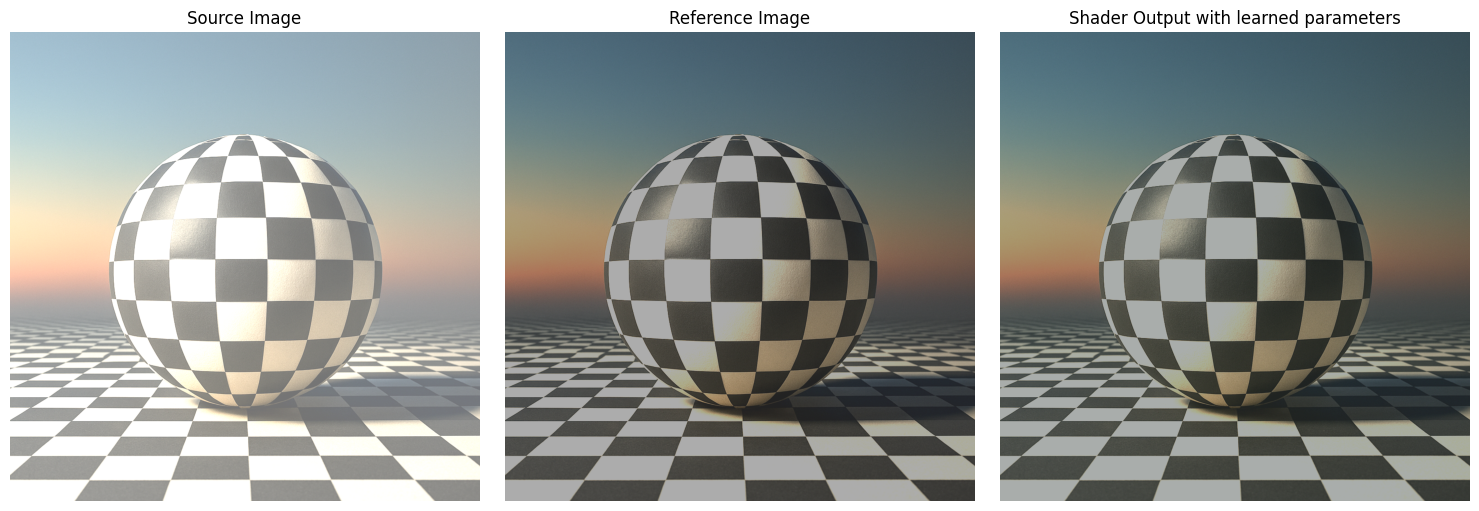

In [19]:
result = module.brightness_inplace(ammount, source_texture).detach().cpu()

fig, axes = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
axes[0].imshow(source_bmp); axes[0].set_title("Source Image")
axes[1].imshow(reference_bmp); axes[1].set_title("Reference Image")
axes[2].imshow(result); axes[2].set_title("Shader Output with learned parameters")
for ax in axes:
    ax.axis("off")
plt.show()


In [8]:
heightmap_bmp = spy.Bitmap("real_map.png").convert(pixel_format=spy.Bitmap.PixelFormat.r, component_type=spy.Bitmap.ComponentType.float32)
heightmap_bmp = np.array(heightmap_bmp)

In [9]:
h, w = 512, 512
u = torch.linspace(0, 1, w)
v = torch.linspace(0, 1, h)
uv_grid = torch.stack(torch.meshgrid(v, u, indexing='ij'), dim=-1).to('cuda')  # shape [H, W, 2]

uv_grid.shape, heightmap_bmp.shape

(torch.Size([512, 512, 2]), (512, 512))

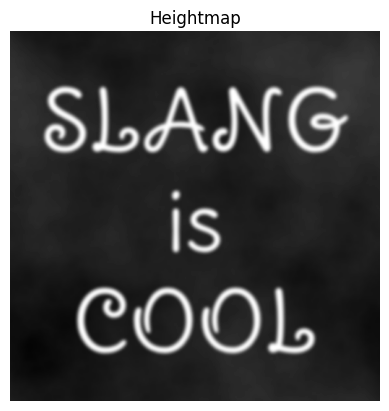

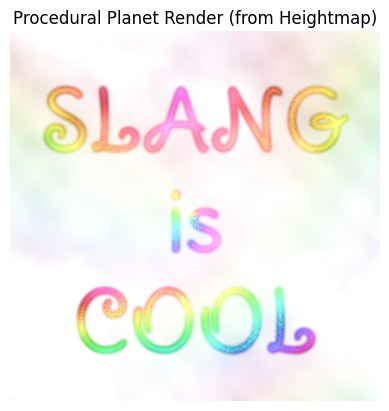

In [10]:
module = spy.TorchModule.load_from_file(device, "examples.slang")
reference_map = module.rainbow(uv_grid, heightmap_bmp)  # shape [H, W, 3]

plt.imshow(
    np.clip(heightmap_bmp, 0, 1),
    cmap='gray',
    vmin=0, vmax=1
)
plt.axis("off")
plt.title("Heightmap")
plt.show()
plt.imshow(np.clip(reference_map.detach().cpu().numpy(), 0, 1))
plt.axis("off")
plt.title("Procedural Planet Render (from Heightmap)")
plt.show()


In [11]:
reference_tensor = reference_map.permute(2, 0, 1).unsqueeze(0)

[    0/3000] loss=0.144258 lr=1.00e-04
[  100/3000] loss=0.130829 lr=3.30e-04
[  200/3000] loss=0.087016 lr=7.82e-04
[  300/3000] loss=0.023608 lr=1.00e-03
[  400/3000] loss=0.006218 lr=9.96e-04
[  500/3000] loss=0.004804 lr=9.86e-04
[  600/3000] loss=0.003994 lr=9.69e-04
[  700/3000] loss=0.003377 lr=9.46e-04
[  800/3000] loss=0.002898 lr=9.17e-04
[  900/3000] loss=0.002541 lr=8.82e-04
[ 1000/3000] loss=0.002283 lr=8.42e-04
[ 1100/3000] loss=0.002101 lr=7.98e-04
[ 1200/3000] loss=0.001986 lr=7.49e-04
[ 1300/3000] loss=0.001874 lr=6.97e-04
[ 1400/3000] loss=0.001810 lr=6.42e-04
[ 1500/3000] loss=0.001756 lr=5.86e-04
[ 1600/3000] loss=0.001709 lr=5.28e-04
[ 1700/3000] loss=0.001680 lr=4.70e-04
[ 1800/3000] loss=0.001653 lr=4.12e-04
[ 1900/3000] loss=0.001630 lr=3.55e-04
[ 2000/3000] loss=0.001617 lr=3.01e-04
[ 2100/3000] loss=0.001605 lr=2.49e-04
[ 2200/3000] loss=0.001593 lr=2.00e-04
[ 2300/3000] loss=0.001590 lr=1.56e-04
[ 2400/3000] loss=0.001582 lr=1.16e-04
[ 2500/3000] loss=0.00157

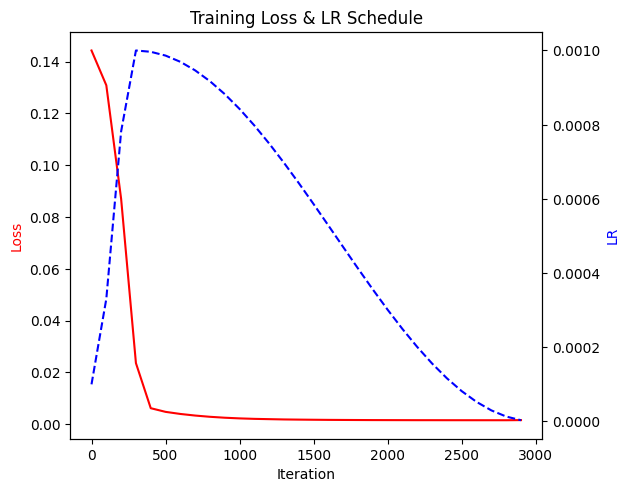

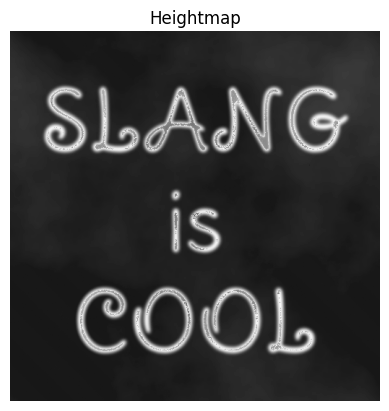

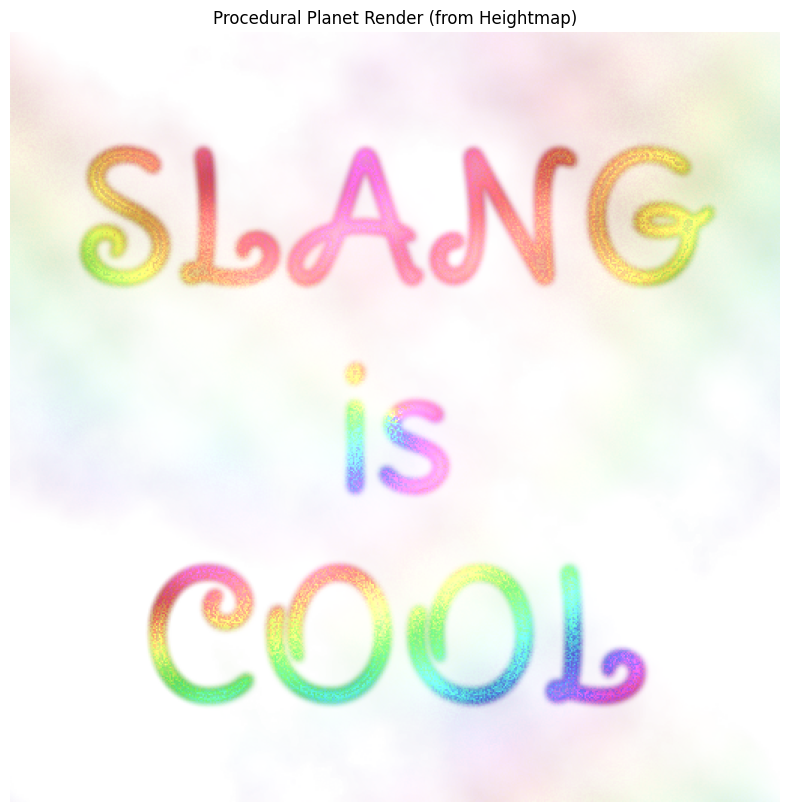

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR  # Add this import
import imageio

def calc_loss(pred, target):
    l1 = F.l1_loss(pred, target)
    huber = F.smooth_l1_loss(pred, target, beta=0.01)
    return 1.0*l1 + 0.5*huber


def setup_optimization(heightmap, iters):
    optimizer = torch.optim.AdamW(
        [heightmap],
        lr=2e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=1e-7, 
        amsgrad=True
    )
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        total_steps=iters,
        pct_start=0.1,
        div_factor=10,
        final_div_factor=1e4,
        anneal_strategy='cos'
    )
    
    return optimizer, scheduler

        
def make_gif(frames, filename='evolution.gif', fps=12):
    # duration per frame in milliseconds:
    duration_ms = 1000.0 / fps
    imageio.mimsave(filename, frames, duration=duration_ms)
    print(f"Saved animation → {filename}")
    

H, W = 512, 512
ITERATIONS = 3000


def plot_metrics(losses, lrs, log_interval):
    steps = np.arange(len(losses)) * log_interval
    fig, ax1 = plt.subplots()
    ax1.plot(steps, losses, 'r-', label='loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss', color='r')
    ax2 = ax1.twinx()
    ax2.plot(steps, lrs, 'b--', label='lr')
    ax2.set_ylabel('LR', color='b')
    fig.tight_layout()
    plt.title("Training Loss & LR Schedule")
    plt.show()
    

# Start with smooth base
heightmap = torch.ones((1, 1, H, W), device='cuda') * 0.3
heightmap = heightmap - torch.randn_like(heightmap) * 0.05
heightmap = heightmap.squeeze().requires_grad_(True)

# Setup optimization
optimizer, scheduler = setup_optimization(heightmap, ITERATIONS)

losses, lrs, frames, heightmaps = [], [], [], []
# Training loop
for i in range(ITERATIONS):
    optimizer.zero_grad()
    
    # Forward pass
    result = module.rainbow(uv_grid, heightmap)
    loss = calc_loss(result, reference_map)
    
    # Backward pass and optimization
    loss.backward()
    # torch.nn.utils.clip_grad_norm_([heightmap], max_norm=0.1)
    optimizer.step()
    scheduler.step()
    
    # Ensure heightmap stays in valid range
    with torch.no_grad():
        heightmap.data.clamp_(0.0, 1.0)
    
    if i % 50 == 0:
        if i % 100 == 0:
            lr = scheduler.get_last_lr()[0]
            print(f"[{i:5d}/{ITERATIONS}] loss={loss:.6f} lr={lr:.2e}")
            losses.append(loss.item())
            lrs.append(lr)
        img = result.detach().cpu().numpy().squeeze()
        img = np.clip(img, 0.0, 1.0) 
        frames.append((img*255).astype(np.uint8))
        img_heightmap = heightmap.detach().cpu().numpy().squeeze()
        img_heightmap = np.clip(img_heightmap, 0.0, 1.0) 
        heightmaps.append((img_heightmap*255).astype(np.uint8))
        

make_gif(frames)
make_gif(heightmaps, "heightmaps.gif")
plot_metrics(losses, lrs, log_interval=100)

plt.imshow(
    np.clip(img_heightmap, 0, 1),
    cmap='gray',
    vmin=0, vmax=1
)
plt.axis("off")
plt.title("Heightmap")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.clip(result.detach().cpu().numpy(), 0, 1))
plt.axis("off")
plt.title("Procedural Planet Render (from Heightmap)")
plt.show()